In [1]:
import math
import numpy as np
import mlflow
import math
# For data handling

# loads uspto dataset and creates translation pairs
from dataset import ReadUsptoDataset 
from helper_utils import tokenize_index_pairs, PositionalEncoding, show_model_layers
from train import train_model

# to get mps to work on mac, need to set this env variable before importing torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from rdkit import RDLogger, Chem
from tqdm.notebook import tqdm
import seaborn as sns


Disabling PyTorch because PyTorch >= 2.4 is required but found 2.3.1
PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#device = "cpu"
print(f'Using device: {device}')

Using device: mps


# 1) Load USPTO and create Translation Pairs

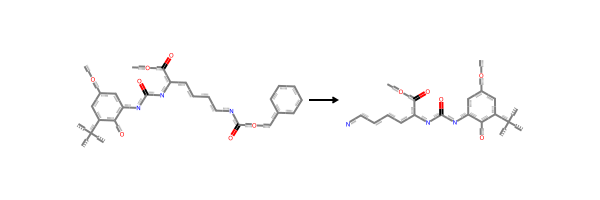

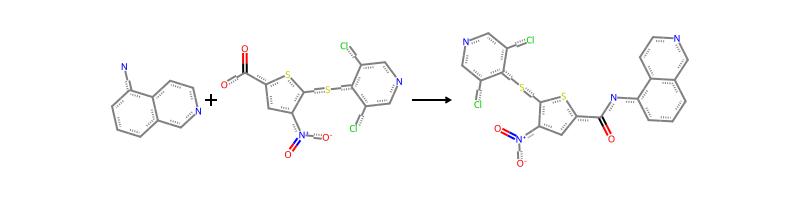

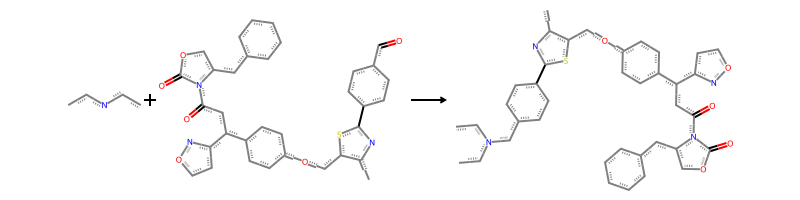

Number of translation pairs: 50016
Example translation pair: ('COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O', 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O')


In [3]:
datareader = ReadUsptoDataset("USPTO_50K.csv")
df_uspto = datareader.load_data()
datareader.visualize_reactions(num_reactions=3)
translation_pairs = datareader.create_translation_pairs()
print(f"Number of translation pairs: {len(translation_pairs)}")
print(f"Example translation pair: {translation_pairs[0]}")


# 2) Tokenization & Build Vocabulary

Next we need to break down our translation pairs into its units: tokens. Here I want to split into tokens that have chemical meaning is for example Cl I want as one token not as two ('C', 'l')

In [4]:
tokenizer = tokenize_index_pairs(translation_pairs)
prepared_pairs, vocab, word2idx, idx2word, max_length = tokenizer.run()

Prepared 50016 translation pairs with max sequence length 93
Example original pair (reactant indices, product indices): ('COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O', 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O')
Example prepared pair (reactant indices, product indices): ([4, 5, 4, 6, 7, 5, 8, 9, 6, 4, 4, 4, 4, 10, 4, 6, 7, 5, 8, 5, 4, 11, 12, 11, 11, 11, 11, 11, 12, 8, 10, 4, 6, 7, 5, 8, 10, 11, 12, 11, 11, 6, 5, 4, 8, 11, 11, 6, 4, 6, 4, 8, 6, 4, 8, 4, 8, 11, 12, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 4, 5, 4, 6, 7, 5, 8, 9, 6, 4, 4, 4, 4, 10, 8, 10, 4, 6, 7, 5, 8, 10, 11, 12, 11, 11, 6, 5, 4, 8, 11, 11, 6, 4, 6, 4, 8, 6, 4, 8, 4, 8, 11, 12, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# 3) Build Dataset and DataLoader

In [5]:
class TranslationDataset(Dataset):
    """
    PyTorch Dataset for translation pairs
    """
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src_indices, tgt_indices = self.pairs[idx]
        
        # Convert to tensors
        src_tensor = torch.tensor(src_indices, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long)
        
        return src_tensor, tgt_tensor

In [6]:
# Create the full dataset
full_dataset = TranslationDataset(prepared_pairs)

# Create random indices for splitting
total_size = len(full_dataset)
indices = list(range(total_size))

# Shuffle indices with seed for reproducibility
torch.manual_seed(42)
indices = torch.randperm(total_size).tolist()

# Calculate split point
split_point_train = int(0.7 * total_size)
split_point_val = int(0.85 * total_size)

# Create train and validation indices
train_indices = indices[:split_point_train]
val_indices = indices[split_point_train:split_point_val]
test_indices = indices[split_point_val:]

# Create subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"Training pairs: {len(train_dataset)}")
print(f"Validation pairs: {len(val_dataset)}")
print(f"Test pairs: {len(test_dataset)}")

# Create data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the data loader
for src_batch, tgt_batch in train_loader:
    print(f"Source batch shape: {src_batch.shape}")
    print(f"Target batch shape: {tgt_batch.shape}")
    # Show first example from batch
    print(f"\nFirst example in batch:")
    src_tokens = [idx2word[idx.item()] for idx in src_batch[0] if idx.item() != word2idx['<pad>']]
    tgt_tokens = [idx2word[idx.item()] for idx in tgt_batch[0] if idx.item() != word2idx['<pad>']]
    print(f"Reactant: {' '.join(src_tokens)}")
    print(f"Product: {' '.join(tgt_tokens)}")
    break

Training pairs: 35011
Validation pairs: 7502
Test pairs: 7503
Source batch shape: torch.Size([64, 93])
Target batch shape: torch.Size([64, 93])

First example in batch:
Reactant: N C ( = O ) c 1 c c ( O c 2 c c c ( N ( C c 3 c c c ( F ) c c 3 ) C ( = O ) C 3 ( C ( N ) = O ) C C 3 ) c c 2 F ) c c n 1
Product: <sos> N C ( = O ) C 1 ( C ( = O ) N ( C c 2 c c c ( F ) c c 2 ) c 2 c c c ( O c 3 c c n c ( N ) c 3 ) c ( F ) c 2 ) C C 1 <eos>


# 4) Building the Encoder-Decoder Architecture

In [7]:
def create_padding_mask(seq, pad_idx=0):
    """
    Create a mask to hide padding tokens
    Args:
        seq: Input sequence tensor [batch_size, seq_length]
        pad_idx: Index used for padding (usually 0)
    Returns:
        Boolean mask where True = ignore this position
    """
    return (seq == pad_idx)

In [8]:
def make_causal_mask(size):
    """
    Create a mask to hide future tokens (for decoder self-attention)
    Args:
        size: Sequence length
    Returns:
        Upper triangular matrix where True = ignore this position
    """
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

In [9]:

class Encoder(nn.Module):
    """
    Encoder: Processes the source (reactants) and creates a context representation
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3, 
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()
        
        # Token embedding: Converts word indices to vectors with input dimension vocab_size, output dimension d_model and the padding_idx being the index 0
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx = 0)
        
        # Generate the positional encoding, by calling the previous defined layer PositionalEncoding, with max length given by max_len and d_model being the embedding dimension
        self.pos_enc = PositionalEncoding(max_len = max_len, d_model = d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout) 
         
        # Define the encoder, by calling nn.TransformerEncoderLayer with the appropriate parameters. Do not forget th pass the dropout value! Include the parameter batch_first = None
        enc_layer = nn.TransformerEncoderLayer(d_model = d_model, 
                                              nhead = nhead, 
                                              dim_feedforward = dim_feedforward, 
                                              dropout = dropout,
                                              batch_first = True)

        # Set the transformer encoder layer by calling the nn.TransformerEncoder with the encoder_layer and the number of layers (given by the parameter)
        self.transformer_encoder = nn.TransformerEncoder(enc_layer,
                                                        num_layers = num_layers,
                                                        enable_nested_tensor=False,)
        
    def forward(self, src):
        """
        Args:
            src: Source language token indices [batch_size, seq_len]
        Returns:
            memory: Encoded representation [batch_size, seq_len, d_model]
        """
        
        # Create padding mask
        padding_mask = create_padding_mask(src)
        
        # Embed tokens and add positional encoding
        src = self.token_emb(src) + self.pos_enc(src)
        
        # Perform dropout using the dropout layer defined above.
        src = self.dropout(src)
        
        # Pass through transformer encoder, by generating the contextual representation and the padding mask, passed in the argument called src_key_padding_mask
        memory = self.transformer_encoder(src, src_key_padding_mask = padding_mask)
        
        return memory, padding_mask

In [10]:
encoder = Encoder(
                vocab_size=len(vocab),
                d_model=256,
                nhead=8,
                num_layers=3,
                dim_feedforward=512,
                max_len=max_length,
                dropout=0.1
)
show_model_layers(encoder)


 Encoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                          19,200
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_encoder            TransformerEncoder              1,581,312
----------------------------------------------------------------------
TOTAL                                                          1,600,512


In [11]:

class Decoder(nn.Module):
    """
    Decoder component for translation (works with encoder output)
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3,
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        
        # Token embedding: Converts target word indices to vectors with input dimension vocab_size, output dimension d_model and the padding_idx being the index 0
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx = 0)
        
        # Generate the positional encoding for target sequence
        self.pos_enc = PositionalEncoding(max_len = max_len, d_model = d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout) 
        
        # Define the decoder layer with the desired parameters
        dec_layer = nn.TransformerDecoderLayer(d_model = d_model,
                                               nhead = nhead,
                                               dim_feedforward = dim_feedforward,
                                               dropout = dropout,
                                               batch_first = True
                                              )
        
        # Set the transformer decoder by passing the decoder layer and the number of layers
        self.transformer_decoder = nn.TransformerDecoder(dec_layer,
                                                          num_layers = num_layers,
                                                        )
        
        # Output projection layer: Projects decoder output to target vocabulary size, it must input the d_model and output vocab_size
        self.output_projection = nn.Linear(d_model, vocab_size)
        
    def forward(self, tgt, memory, memory_padding_mask=None):
        """
        Args:
            tgt: Target language token indices [batch_size, tgt_seq_len]
            memory: Encoder output [batch_size, src_seq_len, d_model]
            memory_padding_mask: Mask for encoder padding [batch_size, src_seq_len]
        Returns:
            output: Predicted token logits [batch_size, tgt_seq_len, vocab_size]
        """
        ### START CODE HERE ###
        
        # Create padding mask for target sequence
        tgt_padding_mask = create_padding_mask(tgt)
        
        # Create subsequent mask to prevent decoder from looking at future tokens
        tgt_seq_len = tgt.size(1)
        tgt_subsequent_mask = make_causal_mask(tgt_seq_len).to(tgt.device)

        # Convert into token embeddings
        tgt = self.token_emb(tgt) * math.sqrt(self.d_model)
        
        # Add positional encoding so model knows word positions
        tgt = tgt + self.pos_enc(tgt)
        
        # Apply dropout to embedded target
        tgt = self.dropout(tgt)
        
        # Pass through transformer decoder with cross-attention to encoder memory
        decoded = self.transformer_decoder(tgt,
                                           memory = memory,
                                           tgt_mask=tgt_subsequent_mask,
                                           tgt_key_padding_mask=tgt_padding_mask,
                                           memory_key_padding_mask = memory_padding_mask
                                          )

        # Project decoder output to vocabulary size
        output = self.output_projection(decoded)
        
        return output

In [12]:
decoder = Decoder(
                vocab_size=len(vocab),
                d_model=256,
                nhead=8,
                num_layers=3,
                dim_feedforward=512,
                max_len=max_length,
                dropout=0.1
)
show_model_layers(decoder)


 Decoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                          19,200
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_decoder            TransformerDecoder              2,372,352
output_projection              Linear                             19,275
----------------------------------------------------------------------
TOTAL                                                          2,410,827


In [13]:
class EncoderDecoder(nn.Module):
    """
    Complete Encoder-Decoder translation model combining encoder and decoder modules
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8,
                 num_enc_layers=3, num_dec_layers=3, dim_feedforward=512,
                 max_len=100, dropout=0.1):
        super().__init__()
        
        
        # Initialize encoder for source language with source vocabulary size
        self.encoder = Encoder(vocab_size=src_vocab_size,
                               d_model=d_model,
                               nhead=nhead,
                               num_layers=num_enc_layers, 
                               dim_feedforward=dim_feedforward,
                               max_len=max_len,
                               dropout=dropout)
        
        # Initialize translation decoder for target language with target vocabulary size  
        self.decoder = Decoder(vocab_size=tgt_vocab_size,
                               d_model=d_model,
                               nhead=nhead,
                               num_layers=num_dec_layers, 
                               dim_feedforward=dim_feedforward,
                               max_len=max_len,
                               dropout=dropout)
        
        
    def forward(self, src, tgt):
        """
        Args:
            x: Source language token indices [batch_size, src_seq_len]
            tgt: Target language token indices [batch_size, tgt_seq_len]
        Returns:
            output: Predicted token logits [batch_size, tgt_seq_len, tgt_vocab_size]
        """
        
        # Encode the source sequence to get memory and source padding mask
        memory, src_padding_mask = self.encoder(src)
        
        # Decode using encoder memory to generate target sequence predictions
        output = self.decoder(tgt, 
                              memory, 
                              src_padding_mask
                             )
        
        
        return output

## 4.1) Instantiate the Model

In [14]:
# Model hyperparameters (in section 4.4)
D_MODEL = 256
NHEAD = 8
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
DIM_FEEDFORWARD = 1024
DROPOUT = 0.1

# Create the model with dynamic vocabulary sizes
model = EncoderDecoder(
    src_vocab_size=len(vocab),
    tgt_vocab_size=len(vocab),  # Uses target language vocab
    d_model=D_MODEL,
    nhead=NHEAD,
    num_enc_layers=NUM_ENC_LAYERS,
    num_dec_layers=NUM_DEC_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    max_len=max_length,
    dropout=DROPOUT
).to(device)

show_model_layers(model)


 EncoderDecoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
encoder                        Encoder                         2,388,480
decoder                        Decoder                         3,198,795
----------------------------------------------------------------------
TOTAL                                                          5,587,275


In [15]:
# Test the model with a sample batch
for src_batch, tgt_batch in train_loader:
    src_batch = src_batch.to(device)
    tgt_batch = tgt_batch.to(device)
    
    # Use all but last token as input to decoder
    tgt_input = tgt_batch[:, :-1]
    
    # Forward pass
    output = model(src_batch, tgt_input)
    
    print(f"Source shape: {src_batch.shape}")
    print(f"Target input shape: {tgt_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output dimension matches target vocabulary: {output.shape[-1] == len(vocab)}")
    
    break

Source shape: torch.Size([64, 93])
Target input shape: torch.Size([64, 92])
Output shape: torch.Size([64, 92, 75])
Output dimension matches target vocabulary: True


# 5) Train the Model

In [16]:
# Initialize optimizer and criterion
NUM_EPOCHS = 50

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,          # lower base LR
    weight_decay=1e-2
)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens

# cosine scheduler -> apparently works better for transformer models, and should step every batch, not epoch
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
    min_lr_ratio = 0.1  # Minimum learning rate as a fraction of the initial LR
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return  min_lr_ratio + (1 - min_lr_ratio) * 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

<Axes: >

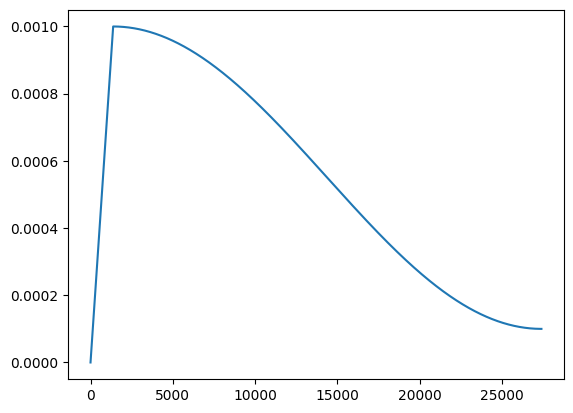

In [17]:
sns.lineplot(x=np.arange(0, total_steps), y=[1e-3 * lr_lambda(step) for step in range(total_steps)])

In [18]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [19]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device, 
    experiment_name="uspto_reaction_transformer",
    run_name="run_50_epochs_lr_1e-3_cos_scheduler"
)


Epoch 1/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.579, Val Loss: 1.068

Current learning rate: 0.000


Epoch 2/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.983, Val Loss: 0.837

Current learning rate: 0.001


Epoch 3/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.817, Val Loss: 0.675

Current learning rate: 0.001


Epoch 4/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.619, Val Loss: 0.459

Current learning rate: 0.001


Epoch 5/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.505, Val Loss: 0.382

Current learning rate: 0.001


Epoch 6/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.439, Val Loss: 0.351

Current learning rate: 0.001


Epoch 7/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.399, Val Loss: 0.304

Current learning rate: 0.001


Epoch 8/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.370, Val Loss: 0.283

Current learning rate: 0.001


Epoch 9/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.344, Val Loss: 0.260

Current learning rate: 0.001


Epoch 10/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.323, Val Loss: 0.242

Current learning rate: 0.001


Epoch 11/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.307, Val Loss: 0.224

Current learning rate: 0.001


Epoch 12/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.294, Val Loss: 0.202

Current learning rate: 0.001


Epoch 13/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.278, Val Loss: 0.193

Current learning rate: 0.001


Epoch 14/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.266, Val Loss: 0.188

Current learning rate: 0.001


Epoch 15/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.257, Val Loss: 0.187

Current learning rate: 0.001


Epoch 16/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.245, Val Loss: 0.165

Current learning rate: 0.001


Epoch 17/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.235, Val Loss: 0.162

Current learning rate: 0.001


Epoch 18/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.226, Val Loss: 0.165

Current learning rate: 0.001


Epoch 19/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.219, Val Loss: 0.150

Current learning rate: 0.001


Epoch 20/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.210, Val Loss: 0.146

Current learning rate: 0.001


Epoch 21/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.200, Val Loss: 0.137

Current learning rate: 0.001


Epoch 22/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.194, Val Loss: 0.135

Current learning rate: 0.001


Epoch 23/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.185, Val Loss: 0.141

Current learning rate: 0.001


Epoch 24/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.179, Val Loss: 0.121

Current learning rate: 0.001


Epoch 25/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.172, Val Loss: 0.124

Current learning rate: 0.001


Epoch 26/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.166, Val Loss: 0.118

Current learning rate: 0.001


Epoch 27/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.158, Val Loss: 0.113

Current learning rate: 0.001


Epoch 28/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.152, Val Loss: 0.114

Current learning rate: 0.000


Epoch 29/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.147, Val Loss: 0.105

Current learning rate: 0.000


Epoch 30/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.140, Val Loss: 0.107

Current learning rate: 0.000


Epoch 31/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 31: Train Loss: 0.134, Val Loss: 0.102

Current learning rate: 0.000


Epoch 32/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 32: Train Loss: 0.129, Val Loss: 0.098

Current learning rate: 0.000


Epoch 33/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 33: Train Loss: 0.123, Val Loss: 0.094

Current learning rate: 0.000


Epoch 34/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 34: Train Loss: 0.119, Val Loss: 0.095

Current learning rate: 0.000


Epoch 35/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 35: Train Loss: 0.114, Val Loss: 0.095

Current learning rate: 0.000


Epoch 36/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 36: Train Loss: 0.110, Val Loss: 0.091

Current learning rate: 0.000


Epoch 37/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 37: Train Loss: 0.106, Val Loss: 0.090

Current learning rate: 0.000


Epoch 38/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 38: Train Loss: 0.102, Val Loss: 0.089

Current learning rate: 0.000


Epoch 39/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 39: Train Loss: 0.098, Val Loss: 0.088

Current learning rate: 0.000


Epoch 40/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 40: Train Loss: 0.095, Val Loss: 0.087

Current learning rate: 0.000


Epoch 41/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 41: Train Loss: 0.091, Val Loss: 0.087

Current learning rate: 0.000


Epoch 42/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 42: Train Loss: 0.088, Val Loss: 0.084

Current learning rate: 0.000


Epoch 43/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 43: Train Loss: 0.087, Val Loss: 0.084

Current learning rate: 0.000


Epoch 44/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 44: Train Loss: 0.083, Val Loss: 0.085

Current learning rate: 0.000


Epoch 45/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 45: Train Loss: 0.081, Val Loss: 0.083

Current learning rate: 0.000


Epoch 46/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 46: Train Loss: 0.079, Val Loss: 0.084

Current learning rate: 0.000


Epoch 47/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 47: Train Loss: 0.078, Val Loss: 0.082

Current learning rate: 0.000


Epoch 48/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 48: Train Loss: 0.077, Val Loss: 0.083

Current learning rate: 0.000


Epoch 49/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 49: Train Loss: 0.075, Val Loss: 0.082

Current learning rate: 0.000


Epoch 50/50 [Train]:   0%|          | 0/548 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 50: Train Loss: 0.075, Val Loss: 0.082

Current learning rate: 0.000
✅ MLflow run logged: b75b63cc041244678287e07ca569ef48
🏃 View run run_50_epochs_lr_1e-3_cos_scheduler at: http://127.0.0.1:8080/#/experiments/1/runs/b75b63cc041244678287e07ca569ef48
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


# 6) Generating translations on the test set

In [20]:
# Silence RDKit globally
RDLogger.DisableLog('rdApp.*')

In [21]:
def generate_products_from_reactants(model, test_loader, word2idx, idx2word, max_length=100, device="cpu"):
    """
    Generate product SMILES from ALL reactant SMILES in test_loader
    Compare predicted SMILES to actual target SMILES
    """
    model.eval()
    model.to(device)
    
    results = {
        "input_reactants_smiles": [],
        "predicted_smiles": [],
        "target_smiles": [],
        "token_accuracy": [],
        "exact_match": [],
        "is_valid_smiles": [],
    }
    
    ignore = {word2idx['<pad>'], word2idx['<sos>'], word2idx['<eos>']}
    # 🆕 Progress bar over test_loader!
    test_iter = tqdm(test_loader, desc="Generating predictions", unit="batch")
    
    with torch.no_grad():
        for src_batch, tgt_batch in test_iter:  # Process ALL batches
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            # 🆕 Process EVERY sample in the batch (batch_size samples)
            for sample_idx in range(src_batch.size(0)):  # Loop over batch dimension
                
                src_tensor = src_batch[sample_idx].unsqueeze(0)  # [1, src_len]
                tgt_target = tgt_batch[sample_idx].tolist()      # [tgt_len]
                
                # Autoregressive decoding
                encoder_memory, src_padding_mask = model.encoder(src_tensor)
                tgt_indices = [word2idx['<sos>']]
                
                for step in range(max_length - 1):
                    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
                    decoder_output = model.decoder(tgt_tensor, memory=encoder_memory, memory_padding_mask=src_padding_mask)
                    next_token_logits = decoder_output[0, -1, :]
                    next_token = torch.argmax(next_token_logits).item()
                    tgt_indices.append(next_token)
                    if next_token == word2idx['<eos>']:
                        break
                
                # Strip special tokens
                pred_seq = [idx for idx in tgt_indices if idx not in ignore]
                tgt_seq  = [idx for idx in tgt_target if idx not in ignore]
                
                # Compute metrics
                #exact_match = int(pred_seq == tgt_seq)
                min_len = min(len(pred_seq), len(tgt_seq))
                token_acc = sum(1 for p, t in zip(pred_seq[:min_len], tgt_seq[:min_len]) if p == t) / min_len if min_len > 0 else 0.0
                
                # To SMILES
                pred_smiles = ''.join(idx2word[idx] for idx in pred_seq)
                tgt_smiles  = ''.join(idx2word[idx] for idx in tgt_seq)
                
                # RDKit validity
                mol = Chem.MolFromSmiles(pred_smiles)  # Silent
                is_valid = mol is not None
                # canonicalize target for fair comparison
                tgt_smiles_canonical = Chem.MolToSmiles(Chem.MolFromSmiles(tgt_smiles)) if Chem.MolFromSmiles(tgt_smiles) else tgt_smiles
                pred_smiles_canonical = Chem.MolToSmiles(Chem.MolFromSmiles(pred_smiles)) if is_valid else pred_smiles
                exact_match = int(pred_smiles_canonical == tgt_smiles_canonical)
                
                src_tokens = [idx2word[idx.item()] for idx in src_tensor[0] if idx.item() != word2idx['<pad>']]
                src_smiles = ''.join(src_tokens)
                
                # Append to growing results
                results["input_reactants_smiles"].append(src_smiles)
                results["predicted_smiles"].append(pred_smiles_canonical)
                results["target_smiles"].append(tgt_smiles_canonical)
                results["token_accuracy"].append(token_acc)
                results["exact_match"].append(exact_match)
                results["is_valid_smiles"].append(is_valid)
    
    # Summary stats
    results["num_examples"] = len(results["predicted_smiles"])
    results["mean_token_accuracy"] = sum(results["token_accuracy"]) / results["num_examples"]
    results["exact_match_accuracy"] = sum(results["exact_match"]) / results["num_examples"]
    results["valid_smiles_pct"] = sum(results["is_valid_smiles"]) / results["num_examples"]
    
    return results


In [22]:
test_results = generate_products_from_reactants(trained_model, test_loader, word2idx, idx2word, max_length)

Generating predictions:   0%|          | 0/118 [00:00<?, ?batch/s]

<Axes: xlabel='token_accuracy', ylabel='Count'>

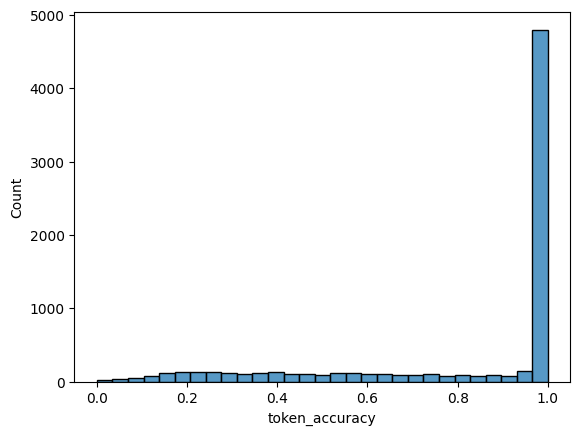

In [23]:

sns.histplot(x="token_accuracy", data=test_results)

calculate exact match accuract: How many predictor SMILES were spot on

In [27]:
test_results["exact_match_accuracy"]

0.6366786618685859